In [83]:
#Bibliotecas em uso
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import json
import graphviz
from datetime import datetime
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.utils import resample
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## Importação dos dados
Foram utilizadas 3 bases de dados:
1. Base com os dados de acidentes nos EUA nos anos de 2016 a 2021
2. Base com o número de veículos nos EUA nos anos de 2016 a 2021 por estado
3. Base com a relação das siglas e o nomes do estados nos EUA.

In [2]:
#Dados base dos acidentes
df = pd.read_csv('I:/OneDrive - det.ufc.br/Cursos Extras/Pos Ciencia de Dados e Big Data/TCC-PucMinas/Database/US_Accidents_Dec21_updated.csv')

In [3]:
#Nomes dos estados
df_state = pd.read_csv('I:/OneDrive - det.ufc.br/Cursos Extras/Pos Ciencia de Dados e Big Data/TCC-PucMinas/Database/state_name.csv',sep=';')

In [4]:
#Arquivos com os volumes de veículos por estados
xls = pd.ExcelFile('I:/OneDrive - det.ufc.br/Cursos Extras/Pos Ciencia de Dados e Big Data/TCC-PucMinas/Database/Vehicle Registration US.xlsx')
df_veh2016 = pd.read_excel(xls, sheet_name='2016')
df_veh2017 = pd.read_excel(xls, sheet_name='2017')
df_veh2018 = pd.read_excel(xls, sheet_name='2018')
df_veh2019 = pd.read_excel(xls, sheet_name='2019')
df_veh2020 = pd.read_excel(xls, sheet_name='2020')
df_veh2021 = pd.read_excel(xls, sheet_name='2021')

## Tratamento dos dados
Tratamento dos dados para que estejam prontos para a análise

In [5]:
#Tratanto para o nome dos estados com nome composto estarem sem espaço
df_veh2016['State'] = df_veh2016['State'].str.replace(' ', '')
df_veh2017['State'] = df_veh2017['State'].str.replace(' ', '')
df_veh2018['State'] = df_veh2018['State'].str.replace(' ', '')
df_veh2019['State'] = df_veh2019['State'].str.replace(' ', '')
df_veh2020['State'] = df_veh2020['State'].str.replace(' ', '')
df_veh2021['State'] = df_veh2021['State'].str.replace(' ', '')
#Colocando o ano como uma coluna em cada uma das tabelas
df_veh2016['Ano'] = 2016
df_veh2017['Ano'] = 2017
df_veh2018['Ano'] = 2018
df_veh2019['Ano'] = 2019
df_veh2020['Ano'] = 2020
df_veh2021['Ano'] = 2021
#Modificando o tipo dessa coluna
df_veh2016['Ano'] = pd.to_datetime(df_veh2016['Ano'], format='%Y')
df_veh2017['Ano'] = pd.to_datetime(df_veh2017['Ano'], format='%Y')
df_veh2018['Ano'] = pd.to_datetime(df_veh2018['Ano'], format='%Y')
df_veh2019['Ano'] = pd.to_datetime(df_veh2019['Ano'], format='%Y')
df_veh2020['Ano'] = pd.to_datetime(df_veh2020['Ano'], format='%Y')
df_veh2021['Ano'] = pd.to_datetime(df_veh2021['Ano'], format='%Y')
#Colocando a sigla do estado em todos
df_veh2016 = pd.merge(df_veh2016, df_state, left_on='State', right_on='Nome', how='left')
df_veh2017 = pd.merge(df_veh2017, df_state, left_on='State', right_on='Nome', how='left')
df_veh2018 = pd.merge(df_veh2018, df_state, left_on='State', right_on='Nome', how='left')
df_veh2019 = pd.merge(df_veh2019, df_state, left_on='State', right_on='Nome', how='left')
df_veh2020 = pd.merge(df_veh2020, df_state, left_on='State', right_on='Nome', how='left')
df_veh2021 = pd.merge(df_veh2021, df_state, left_on='State', right_on='Nome', how='left')
#Renomeando o nome da coluna Total
df_veh2016 = df_veh2016.rename(columns={'Total 2016': 'Total_veh'})
df_veh2017 = df_veh2017.rename(columns={'Total 2017': 'Total_veh'})
df_veh2018 = df_veh2018.rename(columns={'Total 2018': 'Total_veh'})
df_veh2019 = df_veh2019.rename(columns={'Total 2019': 'Total_veh'})
df_veh2020 = df_veh2020.rename(columns={'Total 2020': 'Total_veh'})
df_veh2021 = df_veh2021.rename(columns={'Total 2021': 'Total_veh'})
#Criando um dataframe único para ser usado no merge com a tabela principal
df_veh = pd.concat([df_veh2016,df_veh2017,df_veh2018,df_veh2019,df_veh2020,df_veh2021], axis=0)

In [6]:
# Selecionando somente as colunas necessárias
df_veh_total = df_veh[['Estado','Ano','Total_veh']]

In [7]:
# Transformando as datas para o tipo correto
df['Start_Time'] = pd.to_datetime(df['Start_Time'])
df['End_Time'] = pd.to_datetime(df['End_Time'])

In [ ]:
#Criando o dataframe principal com os dados de acidentes
dados_acidentes = df[['Severity', 'Start_Time', 'End_Time', 'Side', 'City', 'County', 'State', 'Temperature(F)', 'Humidity(%)', 
                      'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Traffic_Signal', 'Sunrise_Sunset']]
#Coluna com os o ano de refência do acidente
dados_acidentes['Ano'] = dados_acidentes['Start_Time'].dt.to_period('Y').dt.to_timestamp()
dados_acidentes['Mes_ano'] = dados_acidentes['Start_Time'].dt.to_period('M').dt.to_timestamp()
#Coluna com a duracão do acidente
dados_acidentes['Duracao(min)'] = ((dados_acidentes['End_Time'] - dados_acidentes['Start_Time']).dt.total_seconds() / 60).astype(int)

In [9]:
#Fazendo merge com a tabela com os dados da quantidade de veículos por estado
dados_acidentes_total = pd.merge(dados_acidentes, df_veh_total, left_on=['State', 'Ano'], right_on=['Estado','Ano'], how='left')
dados_acidentes_total.drop('Estado', axis=1, inplace=True)

In [10]:
#Mudando as colunas necessárias para o tipo categórico ordenado
# 1 representa o menos severo
dados_acidentes_total['Severity'] = dados_acidentes_total['Severity'].astype(pd.CategoricalDtype(categories=[1, 2, 3, 4], ordered=True))
# Categorizando o lado da pista onde ocorreu o acidente
dados_acidentes_total['Side'] = dados_acidentes_total['Side'].astype(pd.CategoricalDtype(categories=['R', 'L', 'N']))

In [11]:
dados_acidentes_total.isnull().sum()

Severity                0
Start_Time              0
End_Time                0
Side                    0
City                  137
County                  0
State                   0
Temperature(F)      69274
Humidity(%)         73092
Pressure(in)        59200
Visibility(mi)      70546
Wind_Direction      73775
Wind_Speed(mph)    157944
Traffic_Signal          0
Sunrise_Sunset       2867
Ano                     0
Mes_ano                 0
Duracao(min)            0
Total_veh               0
dtype: int64

In [12]:
#Formato do dataframe
print('A fonte de dados contem linhas: {:,d} e colunas: {}'.format(dados_acidentes_total.shape[0], dados_acidentes_total.shape[1]))

A fonte de dados contem linhas: 2,845,342 e colunas: 19


In [13]:
#Tratando os valores nulos
# Retirando as linhas com valores nulos de temperatura
dados_acidentes_total = dados_acidentes_total.dropna(subset=['Temperature(F)'])
# Retirando as linhas com valores nulos de Sunrise_Sunset
dados_acidentes_total = dados_acidentes_total.dropna(subset=['Sunrise_Sunset'])
# Retirando as linhas com valores nulos de Wind_Speed(mph)
dados_acidentes_total = dados_acidentes_total.dropna(subset=['Wind_Speed(mph)'])
# Retirando as linhas com valores nulos de Wind_Direction
dados_acidentes_total = dados_acidentes_total.dropna(subset=['Wind_Direction'])
# Retirando as linhas com valores nulos de Visibility(mi) 
dados_acidentes_total = dados_acidentes_total.dropna(subset=['Visibility(mi)'])
# Retirando as linhas com valores nulos de Pressure(in)
dados_acidentes_total = dados_acidentes_total.dropna(subset=['Pressure(in)'])
# Retirando as linhas com valores nulos de Humidity(%)
dados_acidentes_total = dados_acidentes_total.dropna(subset=['Humidity(%)'])

In [14]:
#Formato do dataframe
print('A fonte de dados contem linhas: {:,d} e colunas: {}'.format(dados_acidentes_total.shape[0], dados_acidentes_total.shape[1]))

A fonte de dados contem linhas: 2,662,384 e colunas: 19


In [15]:
dados_acidentes_total.isnull().sum()

Severity           0
Start_Time         0
End_Time           0
Side               0
City               0
County             0
State              0
Temperature(F)     0
Humidity(%)        0
Pressure(in)       0
Visibility(mi)     0
Wind_Direction     0
Wind_Speed(mph)    0
Traffic_Signal     0
Sunrise_Sunset     0
Ano                0
Mes_ano            0
Duracao(min)       0
Total_veh          0
dtype: int64

In [16]:
#Resetando o index do dataframe
dados_acidentes_total = dados_acidentes_total.reset_index(drop=True)
dados_acidentes_total.head(5)

,Severity,Start_Time,End_Time,Side,City,County,State,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Traffic_Signal,Sunrise_Sunset,Ano,Mes_ano,Duracao(min),Total_veh
0,3,2016-02-08 00:37:08,2016-02-08 06:37:08,R,Dublin,Franklin,OH,42.1,58.0,29.76,10.0,SW,10.4,False,Night,2016-01-01,2016-02-01,360,9979600
1,3,2016-02-08 07:53:43,2016-02-08 13:53:43,R,Cincinnati,Hamilton,OH,37.0,93.0,29.69,10.0,WSW,10.4,False,Day,2016-01-01,2016-02-01,360,9979600
2,2,2016-02-08 08:16:57,2016-02-08 14:16:57,R,Williamsburg,Clermont,OH,35.6,100.0,29.66,10.0,WSW,8.1,True,Day,2016-01-01,2016-02-01,360,9979600
3,2,2016-02-08 08:15:41,2016-02-08 14:15:41,R,Dayton,Montgomery,OH,33.8,100.0,29.63,3.0,SW,2.3,False,Day,2016-01-01,2016-02-01,360,9979600
4,2,2016-02-08 11:51:46,2016-02-08 17:51:46,R,Cleveland,Cuyahoga,OH,33.1,92.0,29.63,0.5,SW,3.5,False,Day,2016-01-01,2016-02-01,360,9979600


In [17]:
dados_acidentes_total

,Severity,Start_Time,End_Time,Side,City,County,State,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Traffic_Signal,Sunrise_Sunset,Ano,Mes_ano,Duracao(min),Total_veh
0,3,2016-02-08 00:37:08,2016-02-08 06:37:08,R,Dublin,Franklin,OH,42.1,58.0,29.76,10.0,SW,10.4,False,Night,2016-01-01,2016-02-01,360,9979600
1,3,2016-02-08 07:53:43,2016-02-08 13:53:43,R,Cincinnati,Hamilton,OH,37.0,93.0,29.69,10.0,WSW,10.4,False,Day,2016-01-01,2016-02-01,360,9979600
2,2,2016-02-08 08:16:57,2016-02-08 14:16:57,R,Williamsburg,Clermont,OH,35.6,100.0,29.66,10.0,WSW,8.1,True,Day,2016-01-01,2016-02-01,360,9979600
3,2,2016-02-08 08:15:41,2016-02-08 14:15:41,R,Dayton,Montgomery,OH,33.8,100.0,29.63,3.0,SW,2.3,False,Day,2016-01-01,2016-02-01,360,9979600
4,2,2016-02-08 11:51:46,2016-02-08 17:51:46,R,Cleveland,Cuyahoga,OH,33.1,92.0,29.63,0.5,SW,3.5,False,Day,2016-01-01,2016-02-01,360,9979600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2662379,2,2019-08-23 18:03:25,2019-08-23 18:32:01,R,Riverside,Riverside,CA,86.0,40.0,28.92,10.0,W,13.0,False,Day,2019-01-01,2019-08-01,28,33535000
2662380,2,2019-08-23 19:11:30,2019-08-23 19:38:23,R,San Diego,San Diego,CA,70.0,73.0,29.39,10.0,SW,6.0,False,Day,2019-01-01,2019-08-01,26,33535000
2662381,2,2019-08-23 19:00:21,2019-08-23 19:28:49,R,Orange,Orange,CA,73.0,64.0,29.74,10.0,SSW,10.0,False,Day,2019-01-01,2019-08-01,28,33535000
2662382,2,2019-08-23 19:00:21,2019-08-23 19:29:42,R,Culver City,Los Angeles,CA,71.0,81.0,29.62,10.0,SW,8.0,False,Day,2019-01-01,2019-08-01,29,33535000


In [18]:
dados_acidentes_total['Severity'].value_counts()

2    2388268
3     136151
4     112429
1      25536
Name: Severity, dtype: int64

In [19]:
pd.set_option("display.max_columns", 100)
pd.set_option('display.max_rows', 120)

## Limpeza de dados (Data cleaning)


## Exploração de dados
Exploração inicial dos dados de acidentes nos EUA

In [20]:
dados_acidentes_total.head()

,Severity,Start_Time,End_Time,Side,City,County,State,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Traffic_Signal,Sunrise_Sunset,Ano,Mes_ano,Duracao(min),Total_veh
0,3,2016-02-08 00:37:08,2016-02-08 06:37:08,R,Dublin,Franklin,OH,42.1,58.0,29.76,10.0,SW,10.4,False,Night,2016-01-01,2016-02-01,360,9979600
1,3,2016-02-08 07:53:43,2016-02-08 13:53:43,R,Cincinnati,Hamilton,OH,37.0,93.0,29.69,10.0,WSW,10.4,False,Day,2016-01-01,2016-02-01,360,9979600
2,2,2016-02-08 08:16:57,2016-02-08 14:16:57,R,Williamsburg,Clermont,OH,35.6,100.0,29.66,10.0,WSW,8.1,True,Day,2016-01-01,2016-02-01,360,9979600
3,2,2016-02-08 08:15:41,2016-02-08 14:15:41,R,Dayton,Montgomery,OH,33.8,100.0,29.63,3.0,SW,2.3,False,Day,2016-01-01,2016-02-01,360,9979600
4,2,2016-02-08 11:51:46,2016-02-08 17:51:46,R,Cleveland,Cuyahoga,OH,33.1,92.0,29.63,0.5,SW,3.5,False,Day,2016-01-01,2016-02-01,360,9979600


In [21]:
#Formato do dataframe
print('A fonte de dados contem linhas: {:,d} e colunas: {}'.format(dados_acidentes_total.shape[0], dados_acidentes_total.shape[1]))

A fonte de dados contem linhas: 2,662,384 e colunas: 19


In [22]:
#Colunas de dados disponíveis
df.columns
for n in range(len(dados_acidentes_total.columns)):
    print('Dados sobre: {}'.format(dados_acidentes_total.columns[n]))

Dados sobre: Severity
Dados sobre: Start_Time
Dados sobre: End_Time
Dados sobre: Side
Dados sobre: City
Dados sobre: County
Dados sobre: State
Dados sobre: Temperature(F)
Dados sobre: Humidity(%)
Dados sobre: Pressure(in)
Dados sobre: Visibility(mi)
Dados sobre: Wind_Direction
Dados sobre: Wind_Speed(mph)
Dados sobre: Traffic_Signal
Dados sobre: Sunrise_Sunset
Dados sobre: Ano
Dados sobre: Mes_ano
Dados sobre: Duracao(min)
Dados sobre: Total_veh


In [23]:
#Tipos de dados
dados_acidentes_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2662384 entries, 0 to 2662383
Data columns (total 19 columns):
 #   Column           Dtype         
---  ------           -----         
 0   Severity         category      
 1   Start_Time       datetime64[ns]
 2   End_Time         datetime64[ns]
 3   Side             category      
 4   City             object        
 5   County           object        
 6   State            object        
 7   Temperature(F)   float64       
 8   Humidity(%)      float64       
 9   Pressure(in)     float64       
 10  Visibility(mi)   float64       
 11  Wind_Direction   object        
 12  Wind_Speed(mph)  float64       
 13  Traffic_Signal   bool          
 14  Sunrise_Sunset   object        
 15  Ano              datetime64[ns]
 16  Mes_ano          datetime64[ns]
 17  Duracao(min)     int32         
 18  Total_veh        int64         
dtypes: bool(1), category(2), datetime64[ns](4), float64(5), int32(1), int64(1), object(5)
memory usage: 322.5

In [24]:
#Verificando as severidades dos acidentes
print(dados_acidentes_total['Severity'].value_counts())
print('=================================================')
print(dados_acidentes_total['Severity'].describe())

2    2388268
3     136151
4     112429
1      25536
Name: Severity, dtype: int64
count     2662384
unique          4
top             2
freq      2388268
Name: Severity, dtype: int64


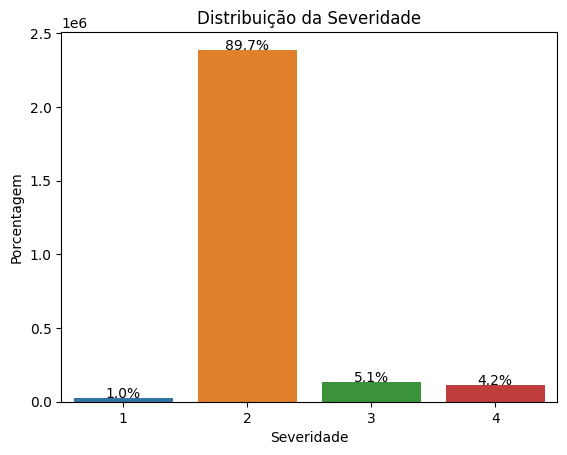

In [25]:
# Proporção da severidade dos acidentes
order = [1, 2, 3, 4]
ax = sns.countplot(x='Severity', order=order, data=dados_acidentes_total)
plt.title('Distribuição da Severidade')
plt.ylabel('Porcentagem')
plt.xlabel('Severidade')

total = float(len(dados_acidentes_total))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3, '{:.1f}%'.format((height / total) * 100), ha='center')

plt.show()

In [26]:
#Colocando os dias da semana e finais de semana
# Adicionando uma coluna com o dia da semana por extenso
dados_acidentes_total['dia_da_semana'] = dados_acidentes_total['Start_Time'].apply(lambda x: x.strftime('%A'))

# Adicionando uma coluna para indicar se é final de semana ou não
dados_acidentes_total['final_de_semana'] = dados_acidentes_total['Start_Time'].apply(lambda x: "final semana" if x.weekday() in [5, 6] else "dia útil")

In [27]:
count = dados_acidentes_total.groupby(['dia_da_semana'])['Severity'].count()
total = dados_acidentes_total['Severity'].count()
count/total * 100

dia_da_semana
Friday       17.363836
Monday       14.683119
Saturday     11.071919
Sunday        9.039718
Thursday     16.305236
Tuesday      15.559100
Wednesday    15.977072
Name: Severity, dtype: float64

In [28]:
counts = dados_acidentes_total.groupby(['dia_da_semana', 'Severity'])['Severity'].count()
total_by_weekday = dados_acidentes_total.groupby(['dia_da_semana'])['Severity'].count()
counts / total_by_weekday * 100

dia_da_semana  Severity
Friday         1            1.049769
               2           89.727488
               3            5.255553
               4            3.967190
Monday         1            1.031155
               2           89.180678
               3            5.384464
               4            4.403703
Saturday       1            0.703922
               2           91.192664
               3            3.851047
               4            4.252367
Sunday         1            0.793196
               2           90.196201
               3            4.089799
               4            4.920805
Thursday       1            1.031310
               2           89.433044
               3            5.522128
               4            4.013517
Tuesday        1            0.970686
               2           89.279722
               3            5.484221
               4            4.265371
Wednesday      1            0.980321
               2           89.539719
              

In [29]:
#Verificando os estados dos acidentes
print(dados_acidentes_total['State'].value_counts().head(10))

CA    743267
FL    387404
TX    140699
OR    116442
NY    102725
VA    102559
PA     95488
MN     92285
NC     86354
SC     85727
Name: State, dtype: int64


In [30]:
# Analisando a severidade dos acidentes dos estados de CA, FL e TX.
tmp_dados_acidentes_total = dados_acidentes_total[dados_acidentes_total['State'].isin(['CA', 'FL', 'TX', 'OR'])]
counts = tmp_dados_acidentes_total.groupby(['State', 'Severity'])['Severity'].count()
total_by_state = dados_acidentes_total.groupby(['State'])['Severity'].count()
counts / total_by_state * 100

State  Severity
CA     1            0.663019
       2           96.201231
       3            2.146200
       4            0.989550
FL     1            0.709595
       2           94.374864
       3            2.698733
       4            2.216807
OR     1            1.077790
       2           93.980694
       3            1.927140
       4            3.014376
TX     1            0.668093
       2           84.022630
       3           12.441453
       4            2.867824
Name: Severity, dtype: float64

In [31]:
# Analisando a temperatura
media = dados_acidentes_total["Temperature(F)"].mean()
desvio_padrao = dados_acidentes_total["Temperature(F)"].std()
valor_minimo = dados_acidentes_total["Temperature(F)"].min()
valor_maximo = dados_acidentes_total["Temperature(F)"].max()
quartis = dados_acidentes_total["Temperature(F)"].quantile([0.25, 0.5, 0.75])

print("Média: ", media)
print("Desvio Padrão: ", desvio_padrao)
print("Valor Mínimo: ", valor_minimo)
print("Valor Máximo: ", valor_maximo)
print("Quartis: ", quartis)

Média:  61.9686160974525
Desvio Padrão:  18.585864696268196
Valor Mínimo:  -33.0
Valor Máximo:  196.0
Quartis:  0.25    50.0
0.50    64.0
0.75    76.0
Name: Temperature(F), dtype: float64


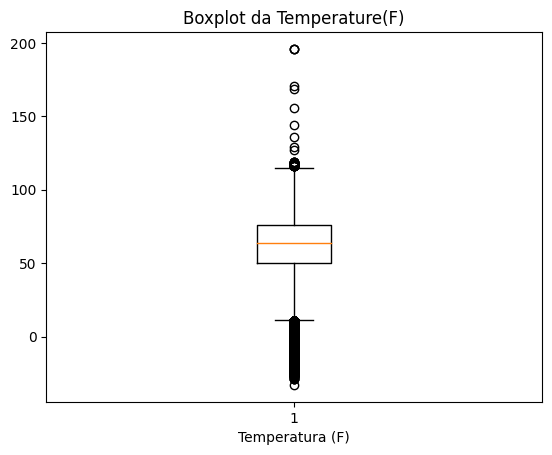

In [32]:
plt.boxplot(dados_acidentes_total["Temperature(F)"])
plt.title("Boxplot da Temperature(F)")
plt.xlabel("Temperatura (F)")
plt.show()

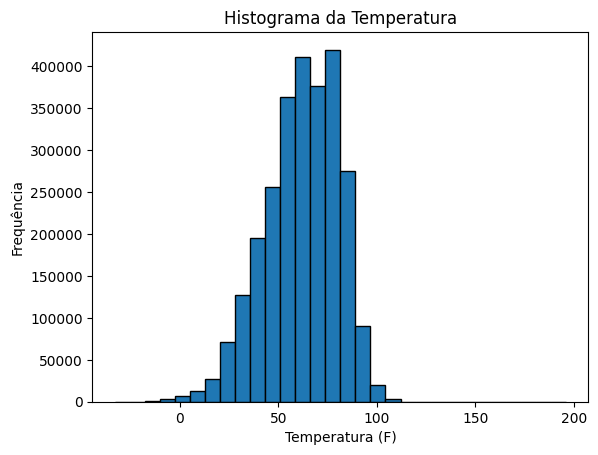

In [33]:
plt.hist(dados_acidentes_total["Temperature(F)"], bins=30, edgecolor='black')
plt.title("Histograma da Temperatura")
plt.xlabel("Temperatura (F)")
plt.ylabel("Frequência")
plt.show()

In [34]:
# Analisando a umidade
media = dados_acidentes_total["Humidity(%)"].mean()
desvio_padrao = dados_acidentes_total["Humidity(%)"].std()
valor_minimo = dados_acidentes_total["Humidity(%)"].min()
valor_maximo = dados_acidentes_total["Humidity(%)"].max()
quartis = dados_acidentes_total["Humidity(%)"].quantile([0.25, 0.5, 0.75])

print("Média: ", media)
print("Desvio Padrão: ", desvio_padrao)
print("Valor Mínimo: ", valor_minimo)
print("Valor Máximo: ", valor_maximo)
print("Quartis: ", quartis)

Média:  64.13776262177056
Desvio Padrão:  22.839088598632834
Valor Mínimo:  1.0
Valor Máximo:  100.0
Quartis:  0.25    48.0
0.50    66.0
0.75    83.0
Name: Humidity(%), dtype: float64


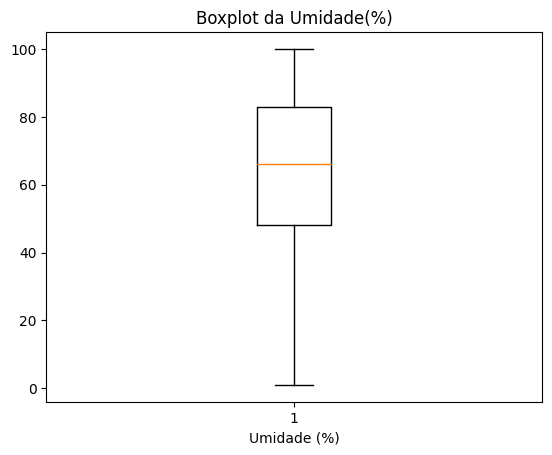

In [35]:
plt.boxplot(dados_acidentes_total["Humidity(%)"])
plt.title("Boxplot da Umidade(%)")
plt.xlabel("Umidade (%)")
plt.show()

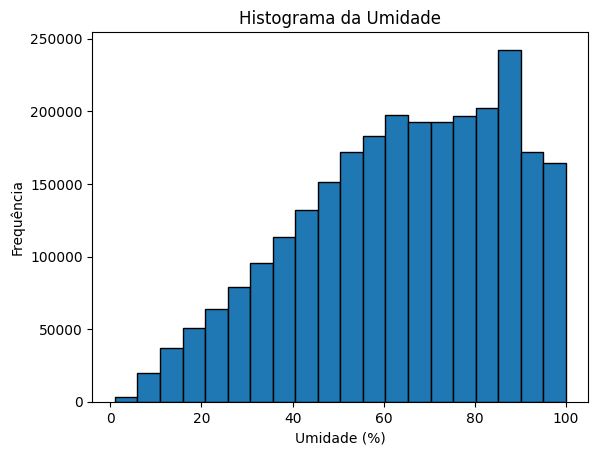

In [36]:
plt.hist(dados_acidentes_total["Humidity(%)"], bins=20, edgecolor='black')
plt.title("Histograma da Umidade")
plt.xlabel("Umidade (%)")
plt.ylabel("Frequência")
plt.show()

In [37]:
# Analisando a velocidade do vento
media = dados_acidentes_total["Wind_Speed(mph)"].mean()
desvio_padrao = dados_acidentes_total["Wind_Speed(mph)"].std()
valor_minimo = dados_acidentes_total["Wind_Speed(mph)"].min()
valor_maximo = dados_acidentes_total["Wind_Speed(mph)"].max()
quartis = dados_acidentes_total["Wind_Speed(mph)"].quantile([0.25, 0.5, 0.75])

print("Média: ", media)
print("Desvio Padrão: ", desvio_padrao)
print("Valor Mínimo: ", valor_minimo)
print("Valor Máximo: ", valor_maximo)
print("Quartis: ", quartis)

Média:  7.396238559125955
Desvio Padrão:  5.5040430738152075
Valor Mínimo:  0.0
Valor Máximo:  1087.0
Quartis:  0.25     3.5
0.50     7.0
0.75    10.0
Name: Wind_Speed(mph), dtype: float64


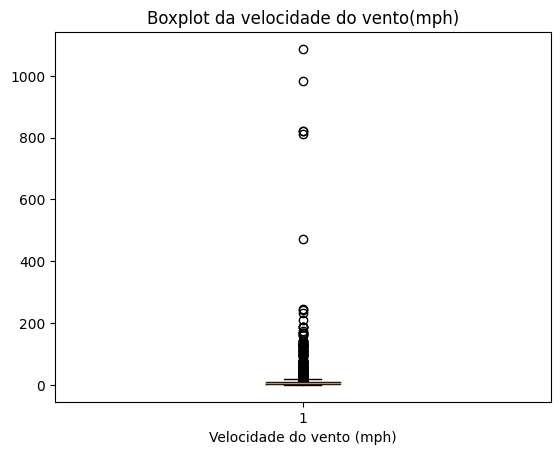

In [38]:
plt.boxplot(dados_acidentes_total["Wind_Speed(mph)"])
plt.title("Boxplot da velocidade do vento(mph)")
plt.xlabel("Velocidade do vento (mph)")
plt.show()

In [39]:
# Analisando as condições climáticas de temperatura e a severidade dos acidentes
dados_acidentes_total.groupby(['Severity'])['Temperature(F)'].mean()

Severity
1    71.226386
2    62.000329
3    62.390612
4    58.681194
Name: Temperature(F), dtype: float64

<Axes: xlabel='Severity', ylabel='Temperature(F)'>

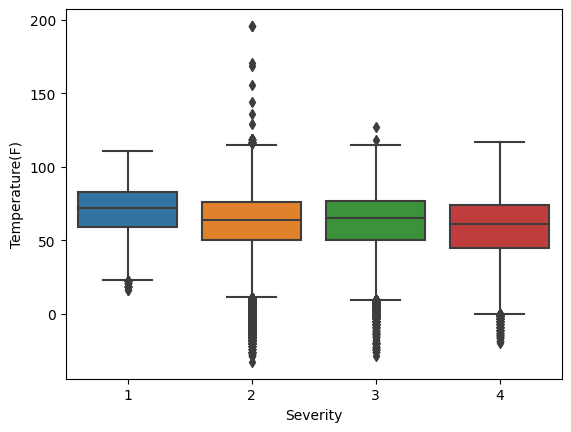

In [40]:
sns.boxplot(data=dados_acidentes_total, x='Severity', y='Temperature(F)')

In [41]:
# Analisando as condições de umidade e a severidade dos acidentes
dados_acidentes_total.groupby(['Severity'])['Humidity(%)'].mean()

Severity
1    50.028117
2    64.223473
3    63.339234
4    66.488806
Name: Humidity(%), dtype: float64

<Axes: xlabel='Severity', ylabel='Humidity(%)'>

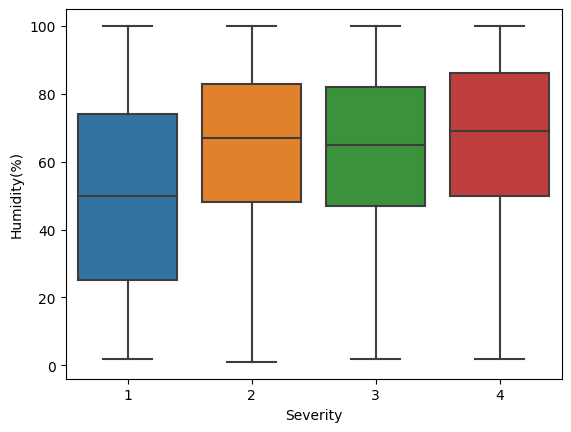

In [42]:
sns.boxplot(data=dados_acidentes_total, x='Severity', y='Humidity(%)')

In [43]:
# Analisando as condições de visibilidade e a severidade dos acidentes
dados_acidentes_total.groupby(['Severity'])['Visibility(mi)'].mean()

Severity
1    9.530995
2    9.087711
3    9.370205
4    9.129725
Name: Visibility(mi), dtype: float64

<Axes: xlabel='Severity', ylabel='Visibility(mi)'>

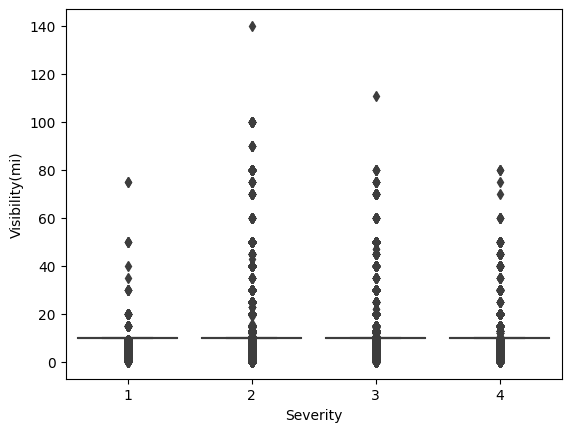

In [44]:
sns.boxplot(data=dados_acidentes_total, x='Severity', y='Visibility(mi)')

In [45]:
# Analisando as condições de velocidade do vento e a severidade dos acidentes
dados_acidentes_total.groupby(['Severity'])['Wind_Speed(mph)'].mean()

Severity
1    8.394110
2    7.265685
3    8.996491
4    8.004964
Name: Wind_Speed(mph), dtype: float64

<Axes: xlabel='Severity', ylabel='Wind_Speed(mph)'>

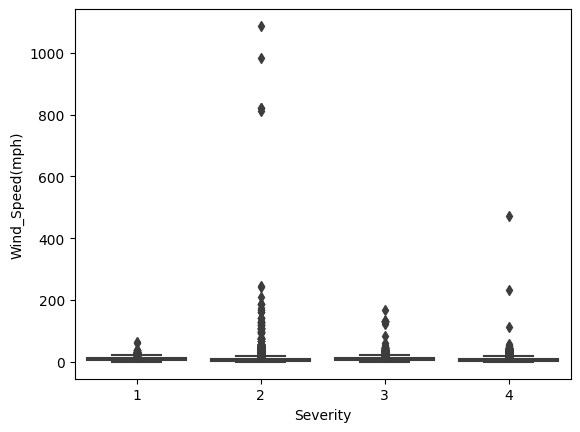

In [46]:
sns.boxplot(data=dados_acidentes_total, x='Severity', y='Wind_Speed(mph)')

In [47]:
# Analisando as condições de presença de semáforo e a severidade dos acidentes
t = dados_acidentes_total.groupby(['Severity'])['Traffic_Signal'].count()
p = dados_acidentes_total.groupby(['Severity','Traffic_Signal'])['Traffic_Signal'].count()
p/t*100

Severity  Traffic_Signal
1         False             53.861216
          True              46.138784
2         False             91.086930
          True               8.913070
3         False             88.643491
          True              11.356509
4         False             89.564970
          True              10.435030
Name: Traffic_Signal, dtype: float64

In [48]:
# Analisando as condições de presença de semáforo e a severidade dos acidentes
t = dados_acidentes_total.groupby(['Severity'])['Sunrise_Sunset'].count()
p = dados_acidentes_total.groupby(['Severity','Sunrise_Sunset'])['Sunrise_Sunset'].count()
p/t*100

Severity  Sunrise_Sunset
1         Day               83.309837
          Night             16.690163
2         Day               63.637917
          Night             36.362083
3         Day               71.081373
          Night             28.918627
4         Day               60.700531
          Night             39.299469
Name: Sunrise_Sunset, dtype: float64

In [49]:
#Colunas de dados utilizados
dados_acidentes.columns
for n in range(len(dados_acidentes_total.columns)):
    print('Dados sobre: {}'.format(dados_acidentes_total.columns[n]))

Dados sobre: Severity
Dados sobre: Start_Time
Dados sobre: End_Time
Dados sobre: Side
Dados sobre: City
Dados sobre: County
Dados sobre: State
Dados sobre: Temperature(F)
Dados sobre: Humidity(%)
Dados sobre: Pressure(in)
Dados sobre: Visibility(mi)
Dados sobre: Wind_Direction
Dados sobre: Wind_Speed(mph)
Dados sobre: Traffic_Signal
Dados sobre: Sunrise_Sunset
Dados sobre: Ano
Dados sobre: Mes_ano
Dados sobre: Duracao(min)
Dados sobre: Total_veh
Dados sobre: dia_da_semana
Dados sobre: final_de_semana


In [50]:
#Formato do dataframe
print('A fonte de dados contem linhas: {:,d} e colunas: {}'.format(dados_acidentes_total.shape[0], dados_acidentes_total.shape[1]))

A fonte de dados contem linhas: 2,662,384 e colunas: 21


## Seleção dos atributos com maior correlação
Analisando os atributos não categóricos.

In [51]:
X_select = dados_acidentes_total.drop(['Severity','Start_Time','End_Time','Ano','Mes_ano','City','County','State','Wind_Direction',
                                       'Sunrise_Sunset','Side','dia_da_semana','final_de_semana'], axis=1)
y_select = dados_acidentes_total['Severity']

In [52]:
X_select

,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Traffic_Signal,Duracao(min),Total_veh
0,42.1,58.0,29.76,10.0,10.4,False,360,9979600
1,37.0,93.0,29.69,10.0,10.4,False,360,9979600
2,35.6,100.0,29.66,10.0,8.1,True,360,9979600
3,33.8,100.0,29.63,3.0,2.3,False,360,9979600
4,33.1,92.0,29.63,0.5,3.5,False,360,9979600
...,...,...,...,...,...,...,...,...
2662379,86.0,40.0,28.92,10.0,13.0,False,28,33535000
2662380,70.0,73.0,29.39,10.0,6.0,False,26,33535000
2662381,73.0,64.0,29.74,10.0,10.0,False,28,33535000
2662382,71.0,81.0,29.62,10.0,8.0,False,29,33535000


In [55]:
selector = SelectKBest(f_classif, k=5)
X_new = selector.fit_transform(X_select, y_select)
selected_features = X_select.columns[selector.get_support()]

var_select = dados_acidentes_total[selected_features]
var_select

,Temperature(F),Humidity(%),Wind_Speed(mph),Traffic_Signal,Total_veh
0,42.1,58.0,10.4,False,9979600
1,37.0,93.0,10.4,False,9979600
2,35.6,100.0,8.1,True,9979600
3,33.8,100.0,2.3,False,9979600
4,33.1,92.0,3.5,False,9979600
...,...,...,...,...,...
2662379,86.0,40.0,13.0,False,33535000
2662380,70.0,73.0,6.0,False,33535000
2662381,73.0,64.0,10.0,False,33535000
2662382,71.0,81.0,8.0,False,33535000


Fora retirados os atributos, "Duracao(min)", "Visibility(mi)" e "Pressure(in)"

## Início do modelo de machine learning
Utilizar 3 modelos diferentes
- Clusterização
- Predição do nível de severidade
- Probabilidade do nível de severidade

Essas são as 3 técnicas de Machine Learning que podem ser usadas para clusterização e predição da severidade dos acidentes de trânsito:

Random Forests (RF): É um algoritmo de aprendizado supervisionado que pode ser usado tanto para classificação quanto para regressão. Ele constrói várias árvores de decisão e combina suas previsões para obter resultados mais precisos e estáveis 1.

Logistic Regression (LR): É um algoritmo de aprendizado supervisionado usado principalmente para problemas de classificação binária. Ele usa uma função logística para modelar a probabilidade de uma observação pertencer a uma das duas classes 1.

Naive Bayes (NB): É um algoritmo de aprendizado supervisionado baseado no teorema de Bayes. Ele assume que as características são independentes entre si e calcula a probabilidade de cada classe dado um conjunto de características 2.


In [87]:
X_kmeans = dados_acidentes_total[['Side','State','Temperature(F)','Humidity(%)',
                            'Wind_Speed(mph)','Traffic_Signal','Sunrise_Sunset',
                            'Total_veh']] # características
X_kmeans = pd.get_dummies(X_kmeans, columns=['Side','State','Traffic_Signal','Sunrise_Sunset'])

In [ ]:
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_kmeans)
    silhouette_scores.append(silhouette_score(X_kmeans, kmeans.labels_))

plt.plot(range(2, 11), silhouette_scores)
plt.xlabel('Número de clusters')
plt.ylabel('Silhouette score')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=42).fit(X_kmeans)

In [ ]:
X_kmeans['cluster'] = kmeans.labels_

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(df['Temperature(F)'], df['Humidity(%)'], c=kmeans.labels_, cmap='rainbow')
ax[0].set_xlabel('Temperature(F)')
ax[0].set_ylabel('Humidity(%)')

ax[1].scatter(df['Temperature(F)'], df['Wind_Speed(mph)'], c=kmeans.labels_, cmap='rainbow')
ax[1].set_xlabel('Temperature(F)')
ax[1].set_ylabel('Wind_Speed(mph)')

ax[2].scatter(df['Total_veh'], df['Traffic_Signal'], c=kmeans.labels_, cmap='rainbow')
ax[2].set_xlabel('Total_veh')
ax[2].set_ylabel('Traffic_Signal')

plt.show()

In [244]:
#Random Forests (RF)

# Carregando os dados
dados_acidentes_encoded = dados_acidentes_total[['Side','State','Temperature(F)','Humidity(%)',
                            'Wind_Speed(mph)','Traffic_Signal','Sunrise_Sunset',
                            'Total_veh']] # características
dados_acidentes_encoded = pd.get_dummies(dados_acidentes_encoded, columns=['Side','State','Traffic_Signal','Sunrise_Sunset'])
X = dados_acidentes_encoded
y = dados_acidentes_total['Severity'] # rótulos

# Dividindo os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Criando o modelo Random Forests
rf_1 = RandomForestClassifier(n_estimators=50)

# Calculando as pontuações de validação cruzada
scores_rf_1 = cross_val_score(rf_1, X_train, y_train, cv=5)
print(f'Pontuações de validação cruzada: {scores_rf_1}')

Pontuações de validação cruzada: [0.9048833  0.90452883 0.90456851 0.90491595 0.90458729]


In [245]:
# Definindo os valores dos hiperparâmetros a serem testados
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 5], #20, 25],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4]
}

# Criando o objeto GridSearchCV
grid_search_rf_1 = GridSearchCV(estimator=rf_1, param_grid=param_grid)

# Ajuste do GridSearchCV aos dados de treinamento
grid_search_rf_1.fit(X_train, y_train)

# Melhores hiperparâmetros encontrados
print(f'Melhores hiperparâmetros: {grid_search_rf_1.best_params_}')

Melhores hiperparâmetros: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}


In [246]:
# Criando um novo modelo Random Forests com os melhores hiperparâmetros encontrados
best_rf_1 = RandomForestClassifier(**grid_search_rf_1.best_params_)

# Treinando o novo modelo com os dados de treinamento
best_rf_1.fit(X_train, y_train)

# Previsões com os dados de teste
y_pred = best_rf_1.predict(X_test)

# Cálculo da acurácia do modelo
accuracy_rf_1 = accuracy_score(y_test, y_pred)
print(f'Acurácia modelo Random Forests (RF_1): {accuracy_rf_1}')

Acurácia modelo Random Forests (RF_1): 0.9103604474935068


array([[  1464,   3534,    121,     10],
       [   329, 471764,   3755,   1604],
       [    69,  18924,   7567,    813],
       [    60,  17124,   1388,   3951]], dtype=int64)

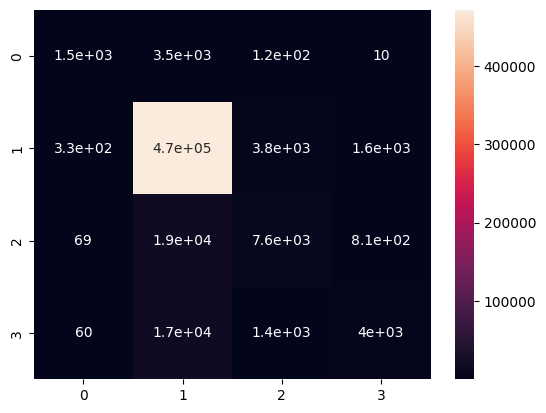

In [247]:
# Matriz de confusão
conf_mat_rf_1 = confusion_matrix(y_test, y_pred)

# Visualizando a matriz de confusão usando Seaborn
sns.heatmap(conf_mat_rf_1, annot=True)

conf_mat_rf_1

In [248]:
# Escolha de uma árvore do modelo Random Forests
estimator = best_rf_1.estimators_[0]

# Exportando a árvore em formato DOT
dot_data = export_graphviz(estimator, out_file=None)

# Gerando a imagem da árvore usando o Graphviz
graph = graphviz.Source(dot_data)
graph.render("tree")

# Demorando mais de 10h com os dados completos

Os hiperparâmetros são parâmetros do modelo que não são aprendidos a partir dos dados, mas são definidos pelo usuário antes do treinamento do modelo. Eles controlam vários aspectos do modelo e podem ter um impacto significativo no desempenho do modelo.

Aqui está o que cada um dos hiperparâmetros do modelo Random Forests significa:

n_estimators: O número de árvores na floresta. Quanto maior o número de árvores, mais robusto será o modelo, mas também mais lento para treinar e fazer previsões.

max_depth: A profundidade máxima das árvores. Isso controla o quão complexas as árvores podem ser. Valores maiores podem levar a um ajuste excessivo (overfitting) dos dados de treinamento.

min_samples_split: O número mínimo de amostras necessárias para dividir um nó interno. Isso controla o quão detalhadas as árvores podem ser. Valores maiores podem levar a árvores mais simples e menos propensas a ajuste excessivo.

min_samples_leaf: O número mínimo de amostras necessárias para estar em um nó folha. Isso controla o tamanho das folhas das árvores. Valores maiores podem levar a árvores mais simples e menos propensas a ajuste excessivo.

Esses são apenas alguns dos hiperparâmetros disponíveis para o modelo Random Forests. Você pode consultar a documentação do scikit-learn para obter uma lista completa dos hiperparâmetros e suas descrições.

Modelo Logistic Regression (LR)

In [57]:
#Logistic Regression (LR)

# Carregando os dados
dados_acidentes_encoded = dados_acidentes_total[['Side','State','Temperature(F)','Humidity(%)',
                            'Wind_Speed(mph)','Traffic_Signal','Sunrise_Sunset',
                            'Total_veh']] # características
dados_acidentes_encoded = pd.get_dummies(dados_acidentes_encoded, columns=['Side','State','Traffic_Signal','Sunrise_Sunset'])
X = dados_acidentes_encoded
y = dados_acidentes_total['Severity'] # rótulos

# Dividindo os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Criando o modelo Logistic Regression
lr_1 = LogisticRegression()

# Treinando o modelo com os dados de treinamento
lr_1.fit(X_train, y_train)

# Fazendo previsões com os dados de teste
y_pred = lr_1.predict(X_test)

# Calculando a acurácia do modelo
accuracy_lr_1 = accuracy_score(y_test, y_pred)
print(f'Acurácia: {accuracy_lr_1}')

Acurácia: 0.8970378063277851


In [60]:
# Definindo os hiperparâmetros a serem ajustados
param_grid = {'C': [0.1, 1, 10], 
              'penalty': ['l2']
              }

# Criando o objeto GridSearchCV
grid_search_lr_1 = GridSearchCV(lr_1, param_grid, error_score='raise')

# Treinando o modelo com os dados de treinamento e ajuste os hiperparâmetros
grid_search_lr_1.fit(X_train, y_train)

# Fazendo previsões com os dados de teste
y_pred = grid_search_lr_1.predict(X_test)

# Calculando a acurácia do modelo
accuracy_lr_1 = accuracy_score(y_test, y_pred)
print(f'Acurácia: {accuracy_lr_1}')

Acurácia: 0.8970378063277851


In [61]:
# Calculando a pontuação de validação cruzada com 5 divisões
scores_lr_1 = cross_val_score(lr_1, X, y, cv=5)

# Imprimindo as pontuações de validação cruzada
print(f'Pontuações de validação cruzada: {scores_lr_1}')

Pontuações de validação cruzada: [0.89703968 0.89704156 0.89704156 0.89704156 0.89704137]


Matriz de confusão: 
[[     0   5090      0      0]
 [     0 477652      0      0]
 [     0  27338      0      0]
 [     0  22397      0      0]]


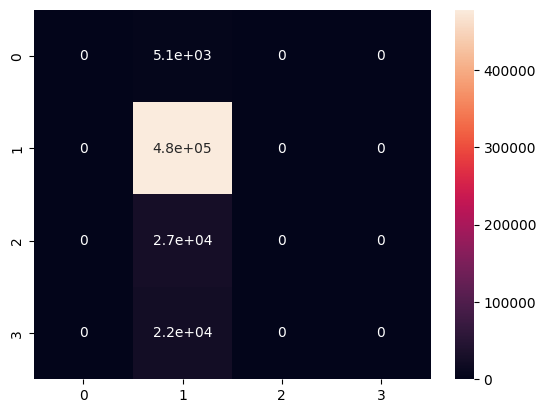

In [62]:
# Matriz de confusão
confusion_mtx = confusion_matrix(y_test, y_pred)
print(f'Matriz de confusão: \n{confusion_mtx}')

# Visualizando a matriz de confusão
sns.heatmap(confusion_mtx, annot=True)
plt.show()

In [63]:
# Carregando os dados
dados_acidentes_encoded = dados_acidentes_total[['Side','State','Temperature(F)','Humidity(%)',
                            'Wind_Speed(mph)','Traffic_Signal','Sunrise_Sunset',
                            'Total_veh']] # características
dados_acidentes_encoded = pd.get_dummies(dados_acidentes_encoded, columns=['Side','State','Traffic_Signal','Sunrise_Sunset'])
X = dados_acidentes_encoded
y = dados_acidentes_total['Severity'] # rótulos

# Dividindo os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Criando o modelo Naive Bayes
nb_1 = GaussianNB()

# Treinando o modelo com os dados de treinamento
nb_1.fit(X_train, y_train)

# Fazendo previsões com os dados de teste
y_pred = nb_1.predict(X_test)

# Calculando a acurácia do modelo
accuracy_nb_1 = accuracy_score(y_test, y_pred)
print(f'Acurácia: {accuracy_nb_1}')

# Este código carrega um conjunto de dados com características X e rótulos y, divide os dados em conjuntos de treinamento e teste e cria um modelo Naive Bayes. 
# O modelo é então treinado com os dados de treinamento e usado para fazer previsões com os dados de teste. 
# Finalmente, a acurácia do modelo é calculada comparando as previsões com os rótulos verdadeiros.

Acurácia: 0.8977721103446722


In [68]:
#Naive Bayes (NB)

# Carregando os dados
dados_acidentes_encoded = dados_acidentes_total[['Side','State','Temperature(F)','Humidity(%)','Pressure(in)',
                            'Visibility(mi)','Wind_Speed(mph)','Traffic_Signal','Sunrise_Sunset',
                            'Duracao(min)','Total_veh']] # características
dados_acidentes_encoded = pd.get_dummies(dados_acidentes_encoded, columns=['Side','State','Traffic_Signal','Sunrise_Sunset'])
X = dados_acidentes_encoded
y = dados_acidentes_total['Severity'] # rótulos

# Dividindo os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Criando o modelo Naive Bayes
nb_1 = GaussianNB()

In [69]:
# Definindo os hiperparâmetros que deseja ajustar e seus valores possíveis
param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7]}

# Criando o objeto GridSearchCV com o modelo e os hiperparâmetros
grid_search_nb_1 = GridSearchCV(nb_1, param_grid=param_grid, cv=5)

# Treinando o modelo com os dados de treinamento e ajuste os hiperparâmetros usando validação cruzada
grid_search_nb_1.fit(X_train, y_train)

# Melhores hiperparâmetros encontrados pelo GridSearchCV
print(f'Melhores hiperparâmetros: {grid_search_nb_1.best_params_}')

Melhores hiperparâmetros: {'var_smoothing': 1e-07}


Acurácia: 0.89688568708132


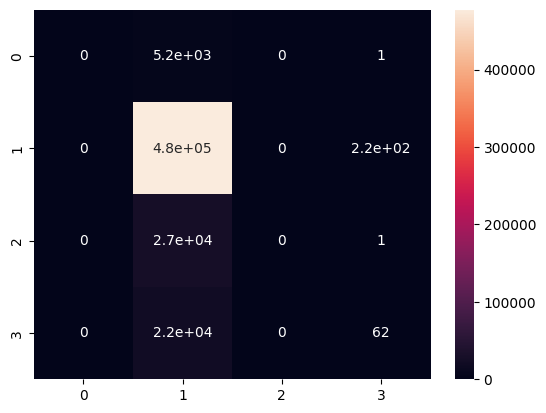

array([[     0,   5203,      0,      1],
       [     0, 477509,      0,    224],
       [     0,  27144,      0,      1],
       [     0,  22333,      0,     62]], dtype=int64)

In [75]:
# Fazendo previsões com os dados de teste usando o melhor modelo encontrado pelo GridSearchCV
y_pred = grid_search_nb_1.predict(X_test)

# Calculando a acurácia do modelo
accuracy_nb_1 = accuracy_score(y_test, y_pred)
print(f'Acurácia: {accuracy_nb_1}')

# Calculando a matriz de confusão
confusion_mat_nb_1 = confusion_matrix(y_test, y_pred)


# Visualizando a matriz de confusão usando um heatmap do seaborn
sns.heatmap(confusion_mat_nb_1, annot=True)
plt.show()

confusion_mat_nb_1

In [78]:
# Repetindo o código para trabalhar com dados balanceados do estado da Califórnia
# Balanceando os dados de acidentes

# Dados de acidentes da Califórnia
dados_acidentes_total_CA = dados_acidentes_total.loc[dados_acidentes_total['State']=='CA']

# Contando o número de amostras de cada categoria
counts = dados_acidentes_total_CA['Severity'].value_counts()

# Verificar o desbalanceamento
print(counts)

# Definindo a categoria com o menor número de amostras
categoria_menor = counts.idxmin()

# Realizando o balanceamento
dados_balanceados = pd.DataFrame()
dados_categoria_balanceados = pd.DataFrame()
for categoria in counts.index:
    dados_categoria = dados_acidentes_total_CA[dados_acidentes_total_CA['Severity'] == categoria]
    if categoria == categoria_menor:
        dados_categoria_balanceados = resample(dados_categoria, replace=True, n_samples=counts.max(), random_state=42)
    else:
        dados_categoria_balanceados = resample(dados_categoria, replace=True, n_samples=counts.max(), random_state=42)
    dados_balanceados = pd.concat([dados_balanceados, dados_categoria_balanceados])

#Dados balanceados
print(dados_balanceados['Severity'].value_counts())

2    715032
3     15952
4      7355
1      4928
Name: Severity, dtype: int64
1    715032
2    715032
3    715032
4    715032
Name: Severity, dtype: int64


### Random Forest (RF)

In [79]:
#Random Forests (RF)

# Carregando os dados
dados_acidentes_encoded = dados_balanceados[['Side','State','Temperature(F)','Humidity(%)',
                            'Wind_Speed(mph)','Traffic_Signal','Sunrise_Sunset',
                            'Total_veh']] # características
dados_acidentes_encoded = pd.get_dummies(dados_acidentes_encoded, columns=['Side','State','Traffic_Signal','Sunrise_Sunset'])
X = dados_acidentes_encoded
y = dados_balanceados['Severity'] # rótulos

# Dividindo os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Criando o modelo Random Forests
rf_2 = RandomForestClassifier(n_estimators=50)

# Calculando as pontuações de validação cruzada
scores_rf_2 = cross_val_score(rf_2, X_train, y_train, cv=5)
print(f'Pontuações de validação cruzada: {scores_rf_2}')

Pontuações de validação cruzada: [0.93990005 0.93999401 0.9392072  0.93940606 0.93949784]


In [80]:
# Definindo os valores dos hiperparâmetros a serem testados
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 5], #20, 25],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4]
}

# Criando o objeto GridSearchCV
grid_search_rf_2 = GridSearchCV(estimator=rf_2, param_grid=param_grid)

# Ajustando o GridSearchCV aos dados de treinamento
grid_search_rf_2.fit(X_train, y_train)

# Melhores hiperparâmetros encontrados
print(f'Melhores hiperparâmetros: {grid_search_rf_2.best_params_}')

Melhores hiperparâmetros: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


In [81]:
# Criando um novo modelo Random Forests com os melhores hiperparâmetros encontrados
best_rf_2 = RandomForestClassifier(**grid_search_rf_2.best_params_)

# Treinando o novo modelo com os dados de treinamento
best_rf_2.fit(X_train, y_train)

# Fazendo previsões com os dados de teste
y_pred = best_rf_2.predict(X_test)

# Calculando a acurácia do modelo
accuracy_rf_2 = accuracy_score(y_test, y_pred)
print(f'Acurácia modelo Random Forests (RF_1): {accuracy_rf_2}')

Acurácia modelo Random Forests (RF_1): 0.9378297489974232


array([[141968,     25,    420,    711],
       [  4251, 124754,   7399,   6063],
       [  4415,    333, 132519,   6152],
       [  3525,    810,   1459, 137222]], dtype=int64)

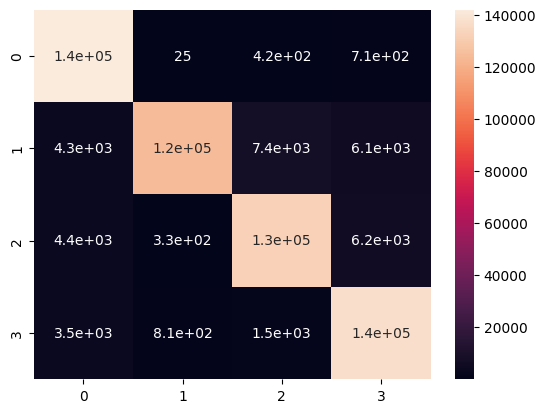

In [82]:
# Matriz de confusão
conf_mat_rf_2 = confusion_matrix(y_test, y_pred)

# Visualizando a matriz de confusão usando Seaborn
sns.heatmap(conf_mat_rf_2, annot=True)

conf_mat_rf_2

In [ ]:
# Escolhendo uma árvore do modelo Random Forests
estimator = best_rf_2.estimators_[0]

# Exportando a árvore em formato DOT
dot_data_2 = export_graphviz(estimator, out_file=None)

# Gerando a imagem da árvore usando o Graphviz
graph = graphviz.Source(dot_data_2)
graph.render("tree")

### Logistic Regression (LR)

In [74]:
#Logistic Regression (LR)

# Carregando os dados
dados_acidentes_encoded = dados_balanceados[['Side','State','Temperature(F)','Humidity(%)',
                            'Wind_Speed(mph)','Traffic_Signal','Sunrise_Sunset','Total_veh']] # características
dados_acidentes_encoded = pd.get_dummies(dados_acidentes_encoded, columns=['Side','State','Traffic_Signal','Sunrise_Sunset'])
X = dados_acidentes_encoded
y = dados_balanceados['Severity'] # rótulos

# Dividindo os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Criando o modelo Logistic Regression
lr_2 = LogisticRegression()

# Treinando o modelo com os dados de treinamento
lr_2.fit(X_train, y_train)

# Fazendo previsões com os dados de teste
y_pred = lr_2.predict(X_test)

# Calculando a acurácia do modelo
accuracy_lr_2 = accuracy_score(y_test, y_pred)
print(f'Acurácia: {accuracy_lr_2}')

Acurácia: 0.2507123802064941


In [75]:
# Definindo os hiperparâmetros a serem ajustados
param_grid = {'C': [10], 
              'penalty': ['l2'],
              'class_weight':['balanced'],
              'fit_intercept':[False]
              }

# Criando o objeto GridSearchCV
grid_search_lr_2 = GridSearchCV(lr_2, param_grid, error_score='raise')

# Treinando o modelo com os dados de treinamento e ajuste os hiperparâmetros
grid_search_lr_2.fit(X_train, y_train)

# Fazendo previsões com os dados de teste
y_pred = grid_search_lr_2.predict(X_test)

# Calculando a acurácia do modelo
accuracy_lr_2 = accuracy_score(y_test, y_pred)
print(f'Acurácia: {accuracy_lr_2}')

Acurácia: 0.2507123802064941


In [76]:
# Calculando a pontuação de validação cruzada com 5 divisões
scores_lr_2 = cross_val_score(lr_2, X, y, cv=5)

# Imprimindo as pontuações de validação cruzada
print(f'Pontuações de validação cruzada: {scores_lr_2}')

Pontuações de validação cruzada: [0.25000087 0.25000087 0.24999913 0.24999956 0.24999956]


Matriz de confusão: 
[[     0 142965      0      0]
 [     0 143414      0      0]
 [     0 142860      0      0]
 [     0 142787      0      0]]


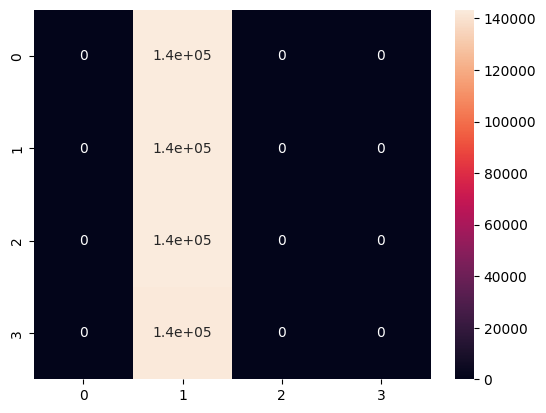

In [77]:
# Calculando a matriz de confusão
confusion_mtx_lr_2 = confusion_matrix(y_test, y_pred)
print(f'Matriz de confusão: \n{confusion_mtx_lr_2}')

# Visualizando a matriz de confusão
sns.heatmap(confusion_mtx_lr_2, annot=True)
plt.show()

### Naive Bayes (NB)

In [69]:
#Naive Bayes (NB)

# Carregando os dados
dados_acidentes_encoded = dados_balanceados[['Side','State','Temperature(F)','Humidity(%)','Pressure(in)',
                            'Visibility(mi)','Wind_Speed(mph)','Traffic_Signal','Sunrise_Sunset',
                            'Duracao(min)','Total_veh']] # características
dados_acidentes_encoded = pd.get_dummies(dados_acidentes_encoded, columns=['Side','State','Traffic_Signal','Sunrise_Sunset'])
X = dados_acidentes_encoded
y = dados_balanceados['Severity'] # rótulos

# Dividindo os dados em conjuntos de treinamento e teste
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Criando o modelo Naive Bayes
nb_2 = GaussianNB()

In [70]:
# Definindo os hiperparâmetros que deseja ajustar e seus valores possíveis
param_grid = {'var_smoothing': [1e-15, 1e-10, 1e-9]}

# Criando o objeto GridSearchCV com o modelo e os hiperparâmetros
grid_search_nb_2 = GridSearchCV(nb_2, param_grid=param_grid, cv=5)

# Treinando o modelo com os dados de treinamento e ajuste os hiperparâmetros usando validação cruzada
grid_search_nb_2.fit(X_train, y_train)

# Imprimindo os melhores hiperparâmetros encontrados pelo GridSearchCV
print(f'Melhores hiperparâmetros: {grid_search_nb_2.best_params_}')

Melhores hiperparâmetros: {'var_smoothing': 1e-10}


Acurácia: 0.5944582841659019


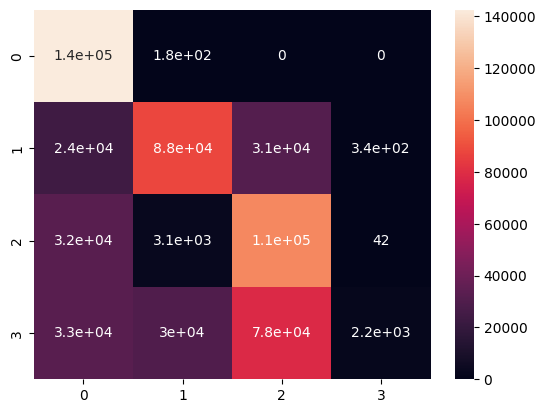

array([[142555,    179,      0,      0],
       [ 23593,  87861,  31298,    342],
       [ 32437,   3063, 107451,     42],
       [ 32814,  30002,  78210,   2178]], dtype=int64)

In [71]:
# Fazendo previsões com os dados de teste usando o melhor modelo encontrado pelo GridSearchCV
y_pred = grid_search_nb_2.predict(X_test)

# Calculando a acurácia do modelo
accuracy_nb_2 = accuracy_score(y_test, y_pred)
print(f'Acurácia: {accuracy_nb_2}')

# Calculando a matriz de confusão
confusion_mat_nb_2 = confusion_matrix(y_test, y_pred)

# Visualizando a matriz de confusão usando um heatmap do seaborn
sns.heatmap(confusion_mat_nb_2, annot=True)
plt.show()

confusion_mat_nb_2

## DataSet das informações por localização (WebScrapping)

In [ ]:
locations = [
    {'latitude': 40.100006, 'longitude': -83.1, 'datahora': '2016-02-08T08:00'},
    {'latitude': 39.9612, 'longitude': -82.9988, 'datahora': '2016-02-08T09:00'},
    {'latitude': 41.8781, 'longitude': -87.6298, 'datahora': '2016-02-08T10:00'}]
data = {
    'latitude': [loc['latitude'] for loc in locations],
    'longitude': [loc['longitude'] for loc in locations],
    'datahora': [loc['datahora'] for loc in locations],
    'temperatura': []}

In [ ]:
df_request = pd.DataFrame()
df_request["Latitude"] = df["Start_Lat"]
df_request["Longitude"] = df["Start_Lng"]
df_request["Time"] = pd.to_datetime(df["Start_Time"]).dt.strftime("%Y-%m-%d")

In [ ]:
len(df_request)

2845342

In [ ]:
df_request.head()

,Latitude,Longitude,Time
0,40.108910,-83.092860,2016-02-08
1,39.865420,-84.062800,2016-02-08
2,39.102660,-84.524680,2016-02-08
3,41.062130,-81.537840,2016-02-08
4,39.172393,-84.492792,2016-02-08


In [ ]:
df_request = df_request.drop_duplicates()

In [ ]:
len(df_request)

2437913

In [ ]:
df_request.head(3)

,Latitude,Longitude,Time
0,40.10891,-83.09286,2016-02-08
1,39.86542,-84.06280,2016-02-08
2,39.10266,-84.52468,2016-02-08


In [ ]:

request = requests.get(f'https://archive-api.open-meteo.com/v1/archive?latitude={}40.108910&longitude=-83.092860&start_date=2016-02-08&end_date=2016-02-08&hourly=apparent_temperature&hourly=precipitation')
df_request = request.json()
df_request

{'latitude': 40.100006,
 'longitude': -83.1,
 'generationtime_ms': 0.6209611892700195,
 'utc_offset_seconds': 0,
 'timezone': 'GMT',
 'timezone_abbreviation': 'GMT',
 'elevation': 270.0,
 'hourly_units': {'time': 'iso8601',
  'apparent_temperature': '°C',
  'precipitation': 'mm'},
 'hourly': {'time': ['2016-02-08T00:00',
   '2016-02-08T01:00',
   '2016-02-08T02:00',
   '2016-02-08T03:00',
   '2016-02-08T04:00',
   '2016-02-08T05:00',
   '2016-02-08T06:00',
   '2016-02-08T07:00',
   '2016-02-08T08:00',
   '2016-02-08T09:00',
   '2016-02-08T10:00',
   '2016-02-08T11:00',
   '2016-02-08T12:00',
   '2016-02-08T13:00',
   '2016-02-08T14:00',
   '2016-02-08T15:00',
   '2016-02-08T16:00',
   '2016-02-08T17:00',
   '2016-02-08T18:00',
   '2016-02-08T19:00',
   '2016-02-08T20:00',
   '2016-02-08T21:00',
   '2016-02-08T22:00',
   '2016-02-08T23:00'],
  'apparent_temperature': [3.2,
   2.8,
   2.0,
   1.0,
   1.1,
   1.1,
   1.0,
   0.9,
   0.2,
   -0.3,
   -0.5,
   -0.5,
   -0.6,
   -1.0,
   -1.

In [ ]:
# Cria um novo dataframe vazio
result_df = pd.DataFrame()

# Itera sobre as linhas do dataframe
for index, row in df.iterrows():
    latitude = row["latitude"]
    longitude = row["longitude"]
    date = row["datetime"].strftime("%Y-%m-%d") # Converte a data para o formato esperado pela API
    url = f'https://archive-api.open-meteo.com/v1/archive?latitude={latitude}&longitude={longitude}&start_date={date}&end_date={date}&hourly=apparent_temperature&hourly=precipitation'
    response = requests.get(url)
    # Processa a resposta aqui
    data = response.json() # Converte a resposta em um dicionário Python
    # Extrai os valores desejados do dicionário
    temperature = data["data"][0]["apparent_temperature"]
    precipitation = data["data"][0]["precipitation"]
    # Cria um novo dicionário com os valores extraídos
    result = {"latitude": latitude, "longitude": longitude, "date": date, "apparent_temperature": temperature, "precipitation": precipitation}
    # Adiciona o novo dicionário ao dataframe de resultados
    result_df = result_df.append(result, ignore_index=True)

In [ ]:
# carrega o json como um dicionário
# dados_json = '{"latitude": 40.100006, "longitude": -83.1, "generationtime_ms": 0.41496753692626953, "utc_offset_seconds": 0, "timezone": "GMT", "timezone_abbreviation": "GMT", "elevation": 270.0, "hourly_units": {"time": "iso8601", "apparent_temperature": "°C", "precipitation": "mm"}, "hourly": {"time": ["2016-02-08T00:00", "2016-02-08T01:00"], "apparent_temperature": [3.2, 2.8], "precipitation": [0.0, 0.0]}}'
dados_dict = (df_request)

# cria um DataFrame a partir do dicionário
df_temp_prec = pd.DataFrame(dados_dict['hourly'])

# verifica se os valores de temperatura e precipitação são listas
if isinstance(df_temp_prec['time'][0], list):
    df_temp_prec['time'] = df_temp_prec['time'].apply(lambda x: x[0])
if isinstance(df_temp_prec['apparent_temperature'][0], list):
    df_temp_prec['apparent_temperature'] = df_temp_prec['apparent_temperature'].apply(lambda x: x[0])
if isinstance(df_temp_prec['precipitation'][0], list):
    df_temp_prec['precipitation'] = df_temp_prec['precipitation'].apply(lambda x: x[0])

# adiciona as informações do tempo ao DataFrame
df_temp_prec['latitude'] = dados_dict['latitude']
df_temp_prec['longitude'] = dados_dict['longitude']

# reorganiza as colunas do DataFrame
df_temp_prec = df_temp_prec[['latitude', 'longitude','time', 'apparent_temperature', 'precipitation']]

# exibe o DataFrame resultante
print(df_temp_prec)

     latitude  longitude              time  apparent_temperature  \
0   40.100006      -83.1  2016-02-08T00:00                   3.2   
1   40.100006      -83.1  2016-02-08T01:00                   2.8   
2   40.100006      -83.1  2016-02-08T02:00                   2.0   
3   40.100006      -83.1  2016-02-08T03:00                   1.0   
4   40.100006      -83.1  2016-02-08T04:00                   1.1   
5   40.100006      -83.1  2016-02-08T05:00                   1.1   
6   40.100006      -83.1  2016-02-08T06:00                   1.0   
7   40.100006      -83.1  2016-02-08T07:00                   0.9   
8   40.100006      -83.1  2016-02-08T08:00                   0.2   
9   40.100006      -83.1  2016-02-08T09:00                  -0.3   
10  40.100006      -83.1  2016-02-08T10:00                  -0.5   
11  40.100006      -83.1  2016-02-08T11:00                  -0.5   
12  40.100006      -83.1  2016-02-08T12:00                  -0.6   
13  40.100006      -83.1  2016-02-08T13:00      

In [ ]:
data = json.loads(df_request.text)